In [1]:
# initialize PYNQ, overlay, xilinx drivers for the rfdc and data buffers
import pynq
from pynq import (Overlay, MMIO)
#from pynq import Xlnk # replace with allocate for Pynq >= 2.7
from pynq import allocate
import xrfclk
import xrfdc
import time
import numpy as np
from numpy import (dtype, int8, int16, float32, complex64)
from numpy import (arange, log10, abs, angle, fft)
import matplotlib.pyplot as plt
import sys

sys.path.append(str("../../mkidgen3/mkidgen3"))  # 将路径转为字符串
from mkidgen3.daccomb import generate_dac_comb
from mkidgen3.plotting import adc_test_plot, plot_opfb_bins
from mkidgen3.drivers import axiswitch, bintores, dactable, axififo, rfdc
from mkidgen3 import capture_opfb, configure

# OVERLAY_PATH = './rfdc_2505202147.bit'
# overlay = Overlay(OVERLAY_PATH)
overlay = configure('./2505231813.bit', clocks=True, external_10mhz=True, ignore_version=True)
print("Inspect all the IP names")
overlay.ip_dict.keys()

Inspect all the IP names


dict_keys(['axi_dma_0', 'snapshot_top_0', 'dac_table', 'axi_dma_1', 'usp_rf_data_converter_0', 'snapshot_recovery128_testdata', 'axi_dma_2', 'snapshot_dac_testdata_0', 'zynq_ultra_ps_e_0'])

In [2]:
# configure rfdc by programming LMX PLL to enable digitization
rfdc = overlay.usp_rf_data_converter_0
xrfclk.set_ref_clks(lmk_freq=100.0, lmx_freq=409.6)

In [3]:
# 设置要发送的频点(Hz)，有效范围[-2047,2048) MHz
# snr设置噪声基底，'max'表示关闭噪声
# tones = np.array([i*10e6 for i in range(100,2000,300)])  # 定义两个频点
tones = np.array([520e6,480e6]) 
# tones = np.array([64e6,170e6,212e6,288e6,320e6,352e6,409e6,434e6,459e6,484e6, 576e6, 682e6,724e6, 800e6,832e6,864e6, 921e6,946e6,971e6,996e6])  # 定义两个频点

# print(tones)
amplitudes = np.ones_like(tones)/tones.shape[0]  # 归一化幅度
snr = 'max'  # 信噪比设置

Ns=2**19  # DAC查找表大小
in_noise = 0  # 初始化噪声
if snr != 'max':
    # 计算噪声幅度
    a_noise = 10**((20*np.log10(1/np.sqrt(2)) - snr)/10)
    # 生成复高斯噪声
    in_noise = np.sqrt(a_noise)*(np.random.uniform(-1,1,size=Ns) + 1j*np.random.uniform(-1,1,size=Ns))
    
# 生成DAC波形(时域IQ信号)
dactable = generate_dac_comb(frequencies=tones, n_samples=Ns, sample_rate=4.096e9, amplitudes=amplitudes)
print(dactable)
if snr != 'max':
    # 添加噪声并归一化
    dactable['iq']+=in_noise
    # dactable['iq']/=max(dactable['iq'].real, dactable['iq'].imag)
    max_amplitude = max(np.abs(dactable['iq']))  # 找到最大幅度值
    dactable['iq'] /= max_amplitude
print(dactable)
print(dactable['iq'].dtype)
print(dactable['iq'].shape)
# np.savetxt('./example_complex.txt', dactable['iq'])
print(dactable['iq'])

{'iq': array([ 0.64179695+0.55857784j,  0.07583383+0.86322325j,
       -0.5538146 +0.6857426j , ..., -0.01117962-0.79885834j,
        0.55869395-0.5961247j ,  0.8332356 -0.04237243j], dtype=complex64), 'frequencies': array([5.2e+08, 4.8e+08]), 'phases': array([0.16294877, 1.26941381])}
{'iq': array([ 0.64179695+0.55857784j,  0.07583383+0.86322325j,
       -0.5538146 +0.6857426j , ..., -0.01117962-0.79885834j,
        0.55869395-0.5961247j ,  0.8332356 -0.04237243j], dtype=complex64), 'frequencies': array([5.2e+08, 4.8e+08]), 'phases': array([0.16294877, 1.26941381])}
complex64
(524288,)
[ 0.64179695+0.55857784j  0.07583383+0.86322325j -0.5538146 +0.6857426j
 ... -0.01117962-0.79885834j  0.55869395-0.5961247j
  0.8332356 -0.04237243j]


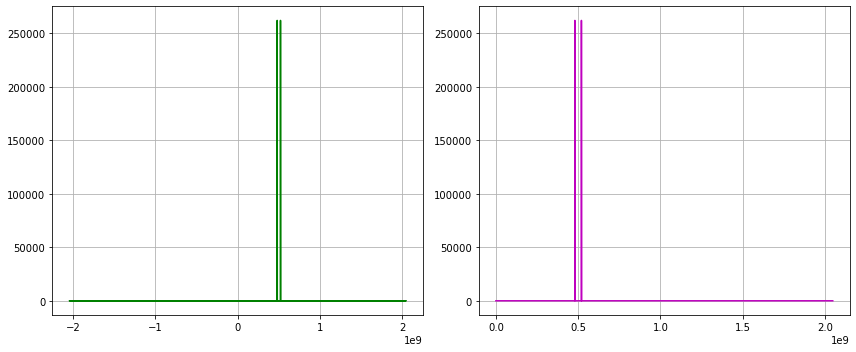

In [4]:
fs = 4.096e9
# 计算FFT（单边谱）
fft_complex = np.fft.fft(dactable['iq'])

freqs_complex = np.fft.fftfreq(Ns, 1/fs)

freqs_fft = np.fft.fftfreq(Ns, 1/fs)  # 频率轴（含负频率）
positive_freqs = freqs_fft[:Ns//2]

# 绘制复数频谱（非对称）
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(freqs_complex, np.abs(fft_complex), 'g')
plt.grid(True)

# 单边谱（仅正频率有意义）
positive_complex = fft_complex[:Ns//2]
plt.subplot(1, 2, 2)
plt.plot(positive_freqs, np.abs(positive_complex), 'm')
plt.grid(True)
plt.tight_layout()
plt.show()

当前有回放正在运行，正在停止...


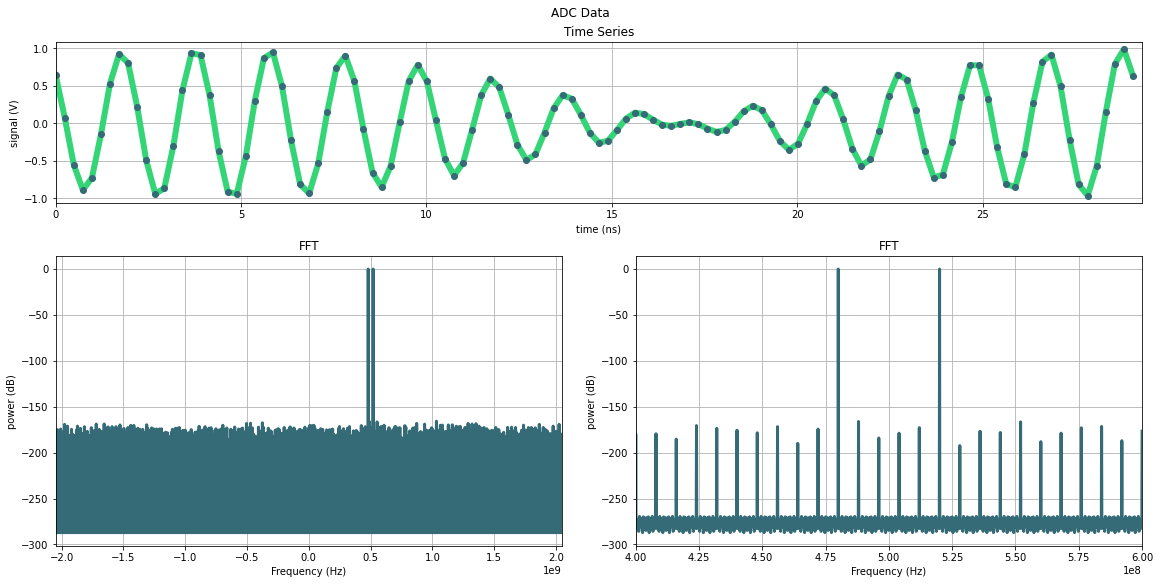

In [5]:
# 编程URAM并运行DAC表
if overlay.dac_table.register_map.run.run:
    print("当前有回放正在运行，正在停止...")
    overlay.dac_table.stop()
    time.sleep(0.1)  # 可选：添加短暂延迟确保完全停止
overlay.dac_table.replay(dactable['iq'], fpgen='simple', stop_if_needed=True)

timerange = (0, 120)
fftrange = (16, 16 + 20*4096)
fftzoom = (4.0e8, 6.0e8)

adc_test_plot(dactable['iq'], timerange, fftrange, fftzoom)

In [6]:
# import numpy as np
# import matplotlib.pyplot as plt

# # ==== 配置参数 ====
# N = 1024                  # 128bit组数（与HLS端length一致）
# SAMPLES = N * 8           # 每组128bit=8x16bit样本
# ADC_BITS = 12             # ADC有效位数（如12bit）
# SHIFT_BITS = 16 - ADC_BITS

# # ==== 假定你已经有PYNQ overlay和DMA初始化如下 ====
# # from pynq import Overlay, allocate
# # ol = Overlay("your.bit")
# dma_i = overlay.axi_dma_2    # 128bit I流DMA
# # dma_q = ol.axi_dma_q    # 128bit Q流DMA
# dma_i_test = overlay.axi_dma_3
# # dma_q_test = ol.axi_dma_q_test

# # ==== 分配DMA缓冲区 ====
# # 128bit=16字节，每组8个int16
# i_buf = allocate(shape=(N,8), dtype=np.int16)
# # q_buf = allocate(shape=(N*8,), dtype=np.int16)
# i_test_buf = allocate(shape=(N,8), dtype=np.int16)
# # q_test_buf = allocate(shape=(N*8,), dtype=np.int16)

# # ==== 触发HLS核工作（你要通过AXI-Lite寄存器启动，或其它方式） ====
# print("start1")
# overlay.snapshot_iq_128bit_0.write(0x10, N)  # 写length寄存器，具体寄存器地址和方法按IP核自动生成文档

# overlay.snapshot_iq_128bit_0.write(0x00,1)
# print("start2")
# # ==== 启动DMA接收 ====
# dma_i.recvchannel.transfer(i_buf)
# # dma_q.recvchannel.transfer(q_buf)
# dma_i_test.recvchannel.transfer(i_test_buf)
# # dma_q_test.recvchannel.transfer(q_test_buf)

# # ==== 等待DMA完成 ====
# print("start3")
# dma_i.recvchannel.wait()
# # dma_q.recvchannel.wait()
# dma_i_test.recvchannel.wait()
# # dma_q_test.recvchannel.wait()
# print("done")
# overlay.snapshot_iq_128bit_0.write(0x00,0)

# # ==== 数据位宽还原 ====
# I_adc_12 = i_buf >> SHIFT_BITS
# Q_adc_12 = q_buf >> SHIFT_BITS

# # ==== 拼复数IQ ====
# IQ = I_adc_12.astype(np.float32) + 1j * I_adc_12.astype(np.float32)

# # ==== 绘制频谱图 ====
# plt.figure(figsize=(10, 5))
# plt.magnitude_spectrum(IQ.flatten(), Fs=1.0, scale='dB', color='blue', label='ADC IQ')
# plt.title('ADC IQ FFT Spectrum')
# plt.xlabel('Normalized Frequency')
# plt.ylabel('Magnitude (dB)')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

# # ==== 打印测试数据（二进制和十进制） ====
# print("=== I_test (前16个样本) ===")
# for i in range(16):
#     bin_str = format(np.uint16(i_test_buf[i]), '016b')
#     print(f"Index {i:2d}: Bin: {bin_str}  Dec: {i_test_buf[i]}")

# print("\n=== Q_test (前16个样本) ===")
# for i in range(16):
#     bin_str = format(np.uint16(q_test_buf[i]), '016b')
#     print(f"Index {i:2d}: Bin: {bin_str}  Dec: {q_test_buf[i]}")

In [7]:
# # 2. 获取DMA实例（名称以你的block design为准，假设为 'axi_dma_0'）
# # dma_test = overlay.axi_dma_3
# dma_pair = overlay.axi_dma_1
# # 2. 采集参数
# N_pkt = 1024       # AXI4-Stream周期数（每周期8组IQ，实际总采样点数=N_pkt*8）
# # dma_test_buffer = allocate(shape=(2**16,1 ), dtype=np.int128,cacheable=1)  # 每周期32字节
# dma_pair_buffer = allocate(shape=(2**16,16 ), dtype=np.uint16,cacheable=1)  # 每周期32字节

# # # 3. DMA采集
# # dma_test.recvchannel.transfer(dma_test_buffer)
# # time.sleep(2)
# # dma_test.recvchannel.wait()
# # print("done")
# dma_pair.recvchannel.transfer(dma_pair_buffer)
# # # time.sleep(2)
# dma_pair.recvchannel.wait()
# print("done")

# # # 3. DMA采集
# # dma_test.recvchannel.transfer(dma_test_buffer)
# # time.sleep(2)
# # dma_test.recvchannel.wait()
# print("done")
# dma_pair.recvchannel.transfer(dma_pair_buffer)
# # time.sleep(2)
# dma_pair.recvchannel.wait()
# print("done")

# np.savetxt('dma_pair_buffer.txt',dma_pair_buffer)

# print("dma_test_buffer and dma_pair_buffer shape:\n")
# # print(dma_test_buffer.shape)
# print(dma_pair_buffer.shape)
# print()

# print("dma_test_buffer and dma_pair_buffer content:\n")
# # print(dma_test_buffer)
# print(dma_pair_buffer)
# print()

# print("dma_test_buffer[0] and dma_pair_buffer[0] content:\n")
# # print(dma_test_buffer[0])
# print(dma_pair_buffer[0])
# print()

# print("max:",dma_pair_buffer.max())
# print("min:",dma_pair_buffer.min())

# print("序号","\t","原无符号值","\t","原值二进制","\t","原值-32768","\t","原值转int","\t","转int后二进制","\t","原值右移4","\t","原值右移4的二进制","\t","")
# for i in range(dma_pair_buffer[0].shape[0]):
#     val = dma_pair_buffer[0][i]
#     print(i,"\t",
#           val, "\t", 
#           format(val, '016b'),"\t",
#           val - 65536 if val >= 32768 else val, "\t", 
#           val.astype(np.int16), "\t", 
#           format(val.astype(np.int16), '016b'),"\t",
#           val>>4,"\t",
#           format(val>>4, '016b'),"\t",
#           (val>>4).astype(np.int16),"\t",
#           val.astype(np.int16)>>4,"\t"
         
#          )  # 固定16位宽

# dma_pair_buffer = dma_pair_buffer >> 4
        
# print("after move:\n",dma_pair_buffer[0])




# # dma_test_buffer_signed = dma_test_buffer
# dma_pair_buffer_signed = dma_pair_buffer.astype(np.int16)

# print("after int:\n",dma_pair_buffer[0])

# # dma_test_buffer_reshape = dma_test_buffer_signed.reshape(-1,2)
# dma_pair_buffer_reshape = dma_pair_buffer_signed.reshape(-1,2)
# print("dma_test_buffer_reshape[i] and dma_pair_buffer_reshape[i] content:\n")
# for i in range(0,16):
#     # print(dma_test_buffer_reshape[i])
#     print(dma_pair_buffer_reshape[i])
#     print()
# print()

# # test_complex_data = dma_test_buffer_reshape[:, 0] + 1j * dma_test_buffer_reshape[:, 1]
# pair_complex_data = dma_pair_buffer_reshape[:, 0] + 1j * dma_pair_buffer_reshape[:, 1]

# print("test_complex_data[i] and pair_complex_data[i] content:\n")
# for i in range(0,20):
#     # print(test_complex_data[i])
#     print(i,pair_complex_data[i])
#     print()
# print()

# print("test_complex_data and pair_complex_data shape:\n")
# # print(test_complex_data.shape)
# print(pair_complex_data.shape)
# print()

# adc_capture_data = pair_complex_data / 2**16

# print(adc_capture_data.shape)
# print(dactable['iq'].shape)

# print("start")

# for i in range(0,20):
#     print(adc_capture_data[i])
#     print(dactable['iq'][i])
#     print()
# # 8. 绘图参数
# timerange = (0, 120)
# fftrange = (16, 16 + 20*4096)
# fftzoom = (4.9e8, 5.1e8)


# # plt.plot(adc_capture_data)
# # plt.show()

# # 9. 用mkidgen3绘图
# adc_test_plot(dactable['iq'], timerange, fftrange, fftzoom)
# adc_test_plot(adc_capture_data, timerange, fftrange, fftzoom)


# # del dma_test_buffer
# del dma_pair_buffer

{'Freq': -500.0, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 0, 'MixerMode': 3, 'FineMixerScale': 1, 'MixerType': 2}
(2048,)
0
0
0
0
-1922
-907
-1123
-1810
132
-2123
1288
-1687
1976
-742
2067
518
1263
-1712
2040
-708
2118
515
1421
1591
307
2118
-893
1923
-1836
1062
(1024, 2)


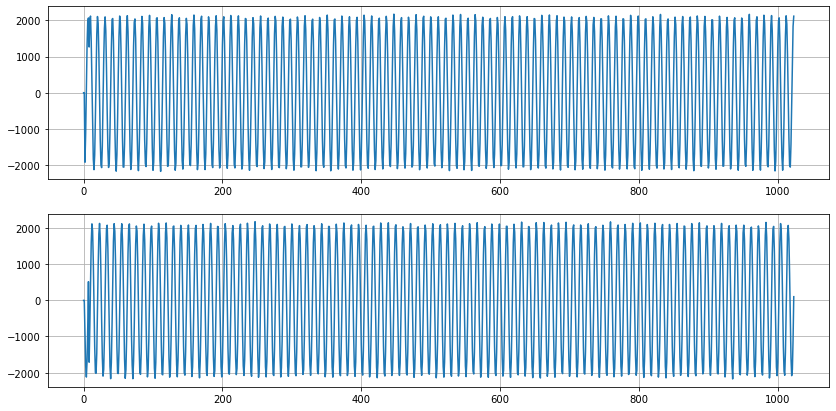

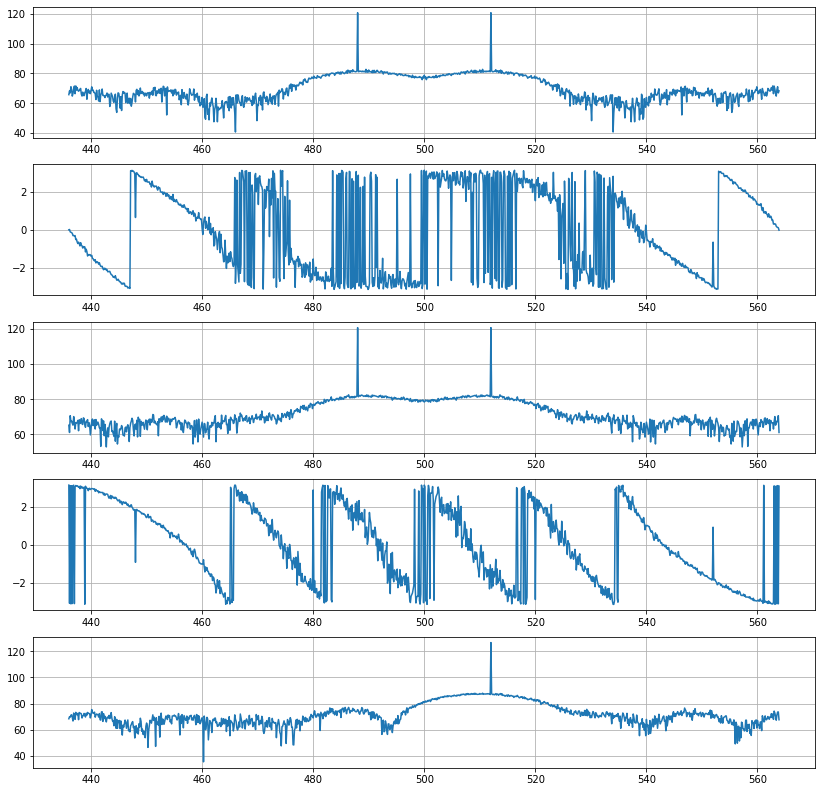

In [8]:
samples = 1024
words_per_pkt = 2
dma = overlay.axi_dma_0
out_buffer = allocate(shape=(samples*words_per_pkt,), dtype='i2', cacheable=1)
# out_buffer = allocate(shape=(samples*words_per_pkt,), dtype=int16, cacheable=1)

def dma_read():
    snapshot_ip.write(0x00,1)
    dma.recvchannel.transfer(out_buffer)
    dma.recvchannel.wait()
    snapshot_ip.write(0x00,0)

# configure snapshot block
# Note that the design will hang and become unresponsive if trying to
# start the snapshot block (writing to anything on this slave) prior to
# the RFDC running (in this case setting the clock starting digitizing)
snapshot_ip = overlay.snapshot_top_0
snapshot_ip.write(0x10, samples)
# example to adjust rfdc and mixer configuration in real-time
adc_tile = rfdc.adc_tiles[0]
adc_block = adc_tile.blocks[0]
adc_block.NyquistZone = 1
adc_block.MixerSettings = {
    'CoarseMixFreq':  xrfdc.COARSE_MIX_BYPASS,
    'EventSource':    xrfdc.EVNT_SRC_TILE,
    'FineMixerScale': xrfdc.MIXER_SCALE_1P0,
    'Freq':           -500.0, # a negative NCO is a shift up
    'MixerMode':      xrfdc.MIXER_MODE_R2C,
    'MixerType':      xrfdc.MIXER_TYPE_FINE,
    'PhaseOffset':    0.0
}
adc_block.UpdateEvent(xrfdc.EVENT_MIXER)

print(adc_block.MixerSettings)
# capture a snapshot and breakout IQ samples
dma_read()
print(out_buffer.shape)
x = out_buffer.reshape(samples,2)
for i in range(0,30):
    print(out_buffer[i])
np.savetxt("snapshot_data.txt",x)
print(x.shape)
# plot IQ time-series
plt.rcParams["figure.figsize"] = (14,7) # set figure size (needs to be ran twice to take effect)
fig, ax = plt.subplots(2,1, sharey='row')
for i in range(0,2):
    cur_ax = ax[i]
    cur_ax.plot(arange(0,samples), x[:,i])
    cur_ax.grid(True)
plt.show()

plt.rcParams["figure.figsize"] = (14,14) # set figure size (needs to be ran twice to take effect)

# combine I and Q to form complex basebanded lowpass equivalent signal and compute spectrum
xl = x[:,0] + 1j*x[:,1]

fs = 2048 # MHz
f_nco = 500.0
dec_factor = adc_block.DecimationFactor
f_baseband = fs/2.0/dec_factor
f_min = f_nco-(f_baseband/2.0)
f_max = f_nco+(f_baseband/2.0)

df = f_baseband/samples
faxis = np.arange(-samples/2.0, samples/2.0) * df + f_nco

X = fft.fft(xl, samples)
X_i = fft.fft(x[:,0], samples)
X_q = fft.fft(x[:,1], samples)

fig, ax = plt.subplots(5,1)
# I magnitude and phase
ax[0].plot(faxis, 20*log10(abs(fft.fftshift(X_i)))); ax[0].grid(True)
ax[1].plot(faxis, angle(X_i)); ax[1].grid(True)
# Q magnitude and phase
ax[2].plot(faxis, 20*log10(abs(fft.fftshift(X_q)))); ax[2].grid(True)
ax[3].plot(faxis, angle(X_q)); ax[3].grid(True)
# lowpass equivalent sepcturm
ax[4].plot(faxis, 20*log10(abs(fft.fftshift(X)))); ax[4].grid(True)
plt.show()

del out_buffer

start rev
done rev
start rev
done rev
max: 32767
min: -32768
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
[1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2]
[2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3]
[3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4]
[4 5 4 5 4 5 4 5 4 5 4 5 4 5 4 5]
[5 6 5 6 5 6 5 6 5 6 5 6 5 6 5 6]
[6 7 6 7 6 7 6 7 6 7 6 7 6 7 6 7]
[7 8 7 8 7 8 7 8 7 8 7 8 7 8 7 8]
[8 9 8 9 8 9 8 9 8 9 8 9 8 9 8 9]
[ 9 10  9 10  9 10  9 10  9 10  9 10  9 10  9 10]
[10 11 10 11 10 11 10 11 10 11 10 11 10 11 10 11]
[11 12 11 12 11 12 11 12 11 12 11 12 11 12 11 12]
[12 13 12 13 12 13 12 13 12 13 12 13 12 13 12 13]
[13 14 13 14 13 14 13 14 13 14 13 14 13 14 13 14]
[14 15 14 15 14 15 14 15 14 15 14 15 14 15 14 15]
[15 16 15 16 15 16 15 16 15 16 15 16 15 16 15 16]
[16 17 16 17 16 17 16 17 16 17 16 17 16 17 16 17]
[17 18 17 18 17 18 17 18 17 18 17 18 17 18 17 18]
[18 19 18 19 18 19 18 19 18 19 18 19 18 19 18 19]
[19 20 19 20 19 20 19 20 19 20 19 20 19 20 19 20]
[20 21 20 21 20 21 20 21 20 21 20 21 20 21 20 21]
[21 22 21 22 21 22 21 22 21 22 21

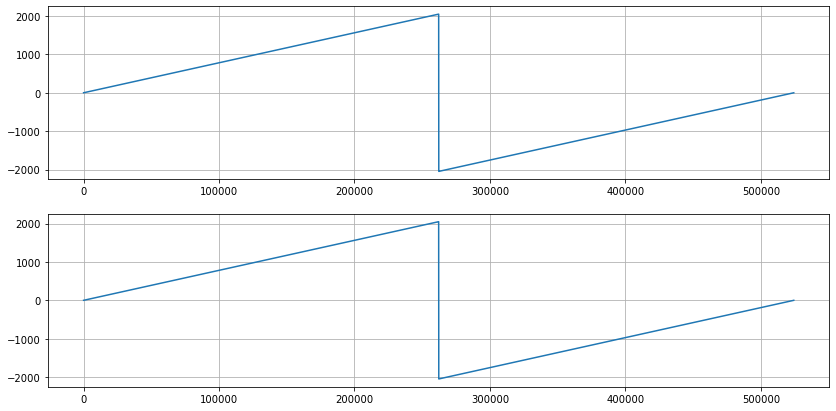

/tmp/ipykernel_192145/2900723215.py:95: RuntimeWarning: divide by zero encountered in log10
  ax[0].plot(faxis, 20*log10(abs(fft.fftshift(X_i)))); ax[0].grid(True)
/tmp/ipykernel_192145/2900723215.py:98: RuntimeWarning: divide by zero encountered in log10
  ax[2].plot(faxis, 20*log10(abs(fft.fftshift(X_q)))); ax[2].grid(True)
/tmp/ipykernel_192145/2900723215.py:101: RuntimeWarning: divide by zero encountered in log10
  ax[4].plot(faxis, 20*log10(abs(fft.fftshift(X)))); ax[4].grid(True)


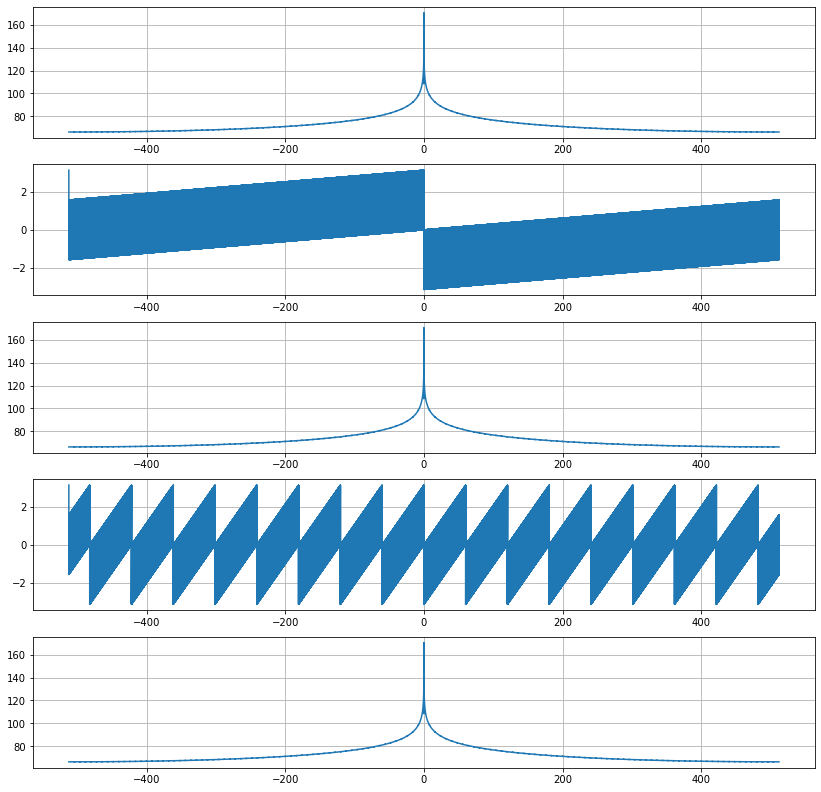

In [9]:
samples = 2**16
dma2 = overlay.axi_dma_1
out_buffer_128 = allocate(shape=(samples,16), dtype=np.int16, cacheable=1)

def dma_read():
    snapshot_ip.write(0x00,1)
    dma2.recvchannel.transfer(out_buffer_128)
    print("start rev")
    dma2.recvchannel.wait()
    print("done rev")
    snapshot_ip.write(0x00,0)

# configure snapshot block
# Note that the design will hang and become unresponsive if trying to
# start the snapshot block (writing to anything on this slave) prior to
# the RFDC running (in this case setting the clock starting digitizing)
snapshot_ip = overlay.snapshot_recovery128_testdata
snapshot_ip.write(0x10, samples)
# capture a snapshot and breakout IQ samples
dma_read()
dma_read()
print("max:",out_buffer_128.max())
print("min:",out_buffer_128.min())

for i in range(0,30):
    print(out_buffer_128[i])
    
# out_buffer_128 = out_buffer_128>>4
# out_buffer_128 = out_buffer_128.view(np.int16)

for i in range(0,30):
    print(out_buffer_128[i])
np.savetxt("snapshot128_data.txt",out_buffer_128)


x = np.array(out_buffer_128)
del out_buffer_128
x = x.reshape(-1,2)
print(x.shape)


print("max:",x.max())
print("min:",x.min())
cnt=0
# for i in range(0,x.shape[0]):
#     for j in range(0,x.shape[1]):
#         if x[i][j] >=32768:
#             x[i][j] -=65536
#             cnt+=1

x = x>>4

print("max:",x.max())
print("min:",x.min())
print("cnt:",cnt)
np.savetxt("snapshot128_data_cut.txt",x)

samples = samples*8



# plot IQ time-series
plt.rcParams["figure.figsize"] = (14,7) # set figure size (needs to be ran twice to take effect)
fig, ax = plt.subplots(2,1, sharey='row')
for i in range(0,2):
    cur_ax = ax[i]
    cur_ax.plot(arange(0,samples), x[:,i])
    cur_ax.grid(True)
plt.show()

plt.rcParams["figure.figsize"] = (14,14) # set figure size (needs to be ran twice to take effect)

# combine I and Q to form complex basebanded lowpass equivalent signal and compute spectrum

# xl= x[:,0] + 1j*x[:,1]
xl= x[:,0]
# adc_capture_data=xl/2**16  #Normalize to 1/2 V

fs = 2048 # MHz
f_nco = 0.0
dec_factor=1
f_baseband = fs/2.0/dec_factor
f_min = f_nco-(f_baseband/2.0)
f_max = f_nco+(f_baseband/2.0)

df = f_baseband/samples
faxis = np.arange(-samples/2.0, samples/2.0) * df + f_nco

X = fft.fft(xl, samples)
X_i = fft.fft(x[:,0], samples)
X_q = fft.fft(x[:,1], samples)

fig, ax = plt.subplots(5,1)
# I magnitude and phase
ax[0].plot(faxis, 20*log10(abs(fft.fftshift(X_i)))); ax[0].grid(True)
ax[1].plot(faxis, angle(X_i)); ax[1].grid(True)
# Q magnitude and phase
ax[2].plot(faxis, 20*log10(abs(fft.fftshift(X_q)))); ax[2].grid(True)
ax[3].plot(faxis, angle(X_q)); ax[3].grid(True)
# lowpass equivalent sepcturm
ax[4].plot(faxis, 20*log10(abs(fft.fftshift(X)))); ax[4].grid(True)
plt.show()


# 当直接用int读取dma数据，并使用右移4时，结果正确

{'Freq': 0.0, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 0, 'MixerMode': 3, 'FineMixerScale': 1, 'MixerType': 2}
(32768, 32)
32672 -32704
original data

[ 21024  18304   2480  28288 -18144  22464 -29120   3648 -23840 -17840
  -4848 -29792  17408 -25120  30304  -6080  26304  16816   7328  30656
 -16128  27392 -30832   8592 -28336 -15312  -9824 -30848  14384 -29152
  30704 -11040]
[ 29840  13392  12208  30384 -12304  30368 -29920  13328 -30752 -11152
 -14368 -29296   9952 -30960  28544 -15312  31008   8736  16176  27632
  -7488  30896 -26608  16912 -30624  -6224 -17536 -25472   4992 -30176
  24240 -18032]
[ 29568   3776  18400  22896  -2608  28800 -21488  18608 -27872  -1488
 -18672 -20032    448 -26800  18512 -18576  25600   -512  18320  16960
   1376  24256 -15392  17904 -22800   2144 -17344 -13824  -2784 -21248
  12272 -16608]
[ 19584  -3312  15728  10752   3696  17856  -9280  14704 -16048   3952
 -13536  -7856  -4048 -14192   6512 -12240  12304  -4000  10800   5248
   380

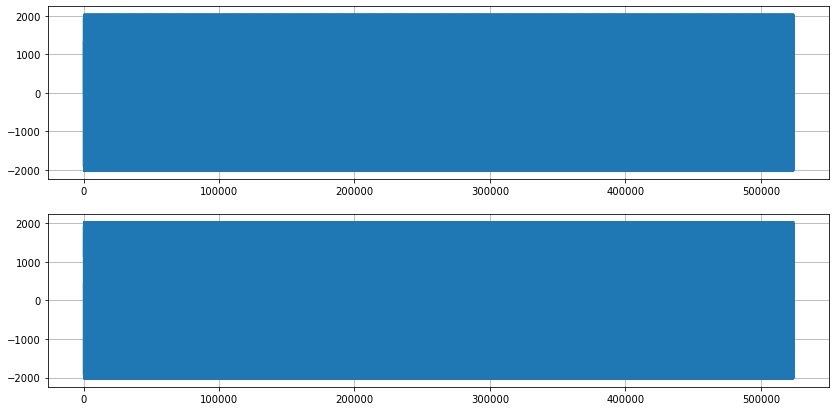

/tmp/ipykernel_192145/3005185310.py:86: RuntimeWarning: divide by zero encountered in log10
  ax[0].plot(faxis, 20*log10(abs(fft.fftshift(X_i)))); ax[0].grid(True)
/tmp/ipykernel_192145/3005185310.py:89: RuntimeWarning: divide by zero encountered in log10
  ax[2].plot(faxis, 20*log10(abs(fft.fftshift(X_q)))); ax[2].grid(True)
/tmp/ipykernel_192145/3005185310.py:92: RuntimeWarning: divide by zero encountered in log10
  ax[4].plot(faxis, 20*log10(abs(fft.fftshift(X)))); ax[4].grid(True)


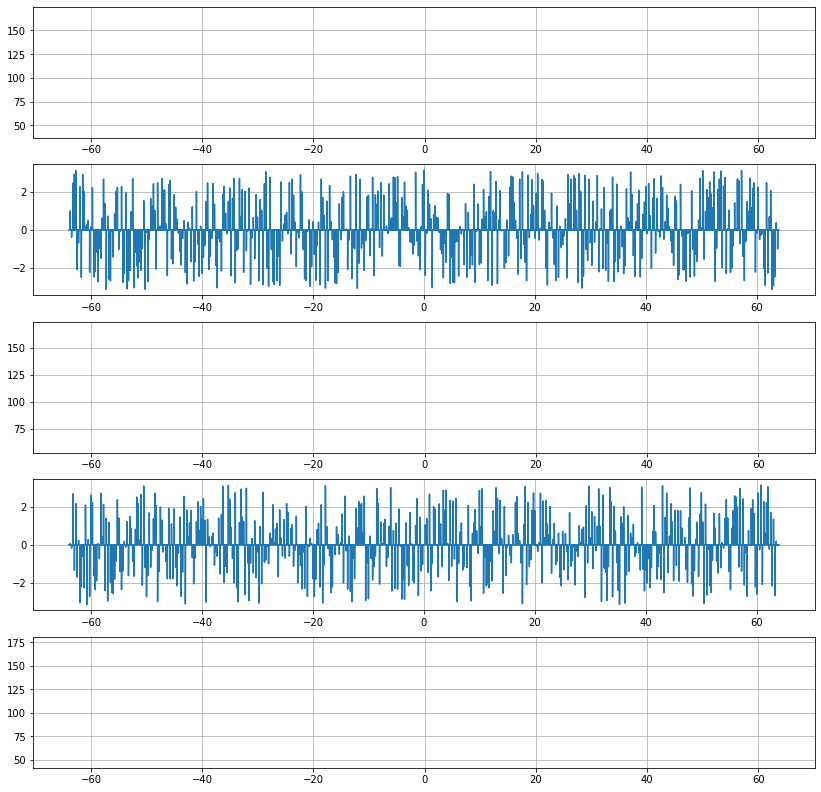

In [39]:
samples = 2**15
words_per_pkt = 2
dma = overlay.axi_dma_2
out_buffer = allocate(shape=(samples,32), dtype=np.int16, cacheable=1)
# out_buffer = allocate(shape=(samples*words_per_pkt,), dtype=int16, cacheable=1)

def dma_read():
    snapshot_ip.write(0x00,1)
    dma.recvchannel.transfer(out_buffer)
    dma.recvchannel.wait()
    snapshot_ip.write(0x00,0)

# configure snapshot block
# Note that the design will hang and become unresponsive if trying to
# start the snapshot block (writing to anything on this slave) prior to
# the RFDC running (in this case setting the clock starting digitizing)
snapshot_ip = overlay.snapshot_dac_testdata_0
snapshot_ip.write(0x10, samples)
# example to adjust rfdc and mixer configuration in real-time
adc_tile = rfdc.adc_tiles[0]
adc_block = adc_tile.blocks[0]
adc_block.NyquistZone = 1
adc_block.MixerSettings = {
    'CoarseMixFreq':  xrfdc.COARSE_MIX_BYPASS,
    'EventSource':    xrfdc.EVNT_SRC_TILE,
    'FineMixerScale': xrfdc.MIXER_SCALE_1P0,
    'Freq':           000.0, # a negative NCO is a shift up
    'MixerMode':      xrfdc.MIXER_MODE_R2C,
    'MixerType':      xrfdc.MIXER_TYPE_FINE,
    'PhaseOffset':    0.0
}
adc_block.UpdateEvent(xrfdc.EVENT_MIXER)

print(adc_block.MixerSettings)
# capture a snapshot and breakout IQ samples
dma_read()
print(out_buffer.shape)
print(out_buffer.max(),out_buffer.min())
print("original data\n")
for i in range(0,30):
    print(out_buffer[i])
x = out_buffer.reshape(-1,2)
print(x.shape)
print(x.max(),x.min())
print("reshape data\n")
for i in range(0,30):
    print(x[i])
x=x>>4
print(x.shape)
print(x.max(),x.min())
print(">>4 data\n")
for i in range(0,30):
    print(x[i])
np.savetxt("snapshot_data.txt",x)
# plot IQ time-series
plt.rcParams["figure.figsize"] = (14,7) # set figure size (needs to be ran twice to take effect)
fig, ax = plt.subplots(2,1, sharey='row')
for i in range(0,2):
    cur_ax = ax[i]
    cur_ax.plot(arange(0,x.shape[0]), x[:,i])
    cur_ax.grid(True)
plt.show()

plt.rcParams["figure.figsize"] = (14,14) # set figure size (needs to be ran twice to take effect)

# combine I and Q to form complex basebanded lowpass equivalent signal and compute spectrum
xl = x[:,0] + 1j*x[:,1]

samples = samples*16
fs = 2048 # MHz
f_nco = 000.0
dec_factor = adc_block.DecimationFactor
f_baseband = fs/2.0/dec_factor
f_min = f_nco-(f_baseband/2.0)
f_max = f_nco+(f_baseband/2.0)

df = f_baseband/samples
faxis = np.arange(-samples/2.0, samples/2.0) * df + f_nco

X = fft.fft(xl, samples)
X_i = fft.fft(x[:,0], samples)
X_q = fft.fft(x[:,1], samples)

fig, ax = plt.subplots(5,1)
# I magnitude and phase
ax[0].plot(faxis, 20*log10(abs(fft.fftshift(X_i)))); ax[0].grid(True)
ax[1].plot(faxis, angle(X_i)); ax[1].grid(True)
# Q magnitude and phase
ax[2].plot(faxis, 20*log10(abs(fft.fftshift(X_q)))); ax[2].grid(True)
ax[3].plot(faxis, angle(X_q)); ax[3].grid(True)
# lowpass equivalent sepcturm
ax[4].plot(faxis, 20*log10(abs(fft.fftshift(X)))); ax[4].grid(True)
plt.show()

del out_buffer

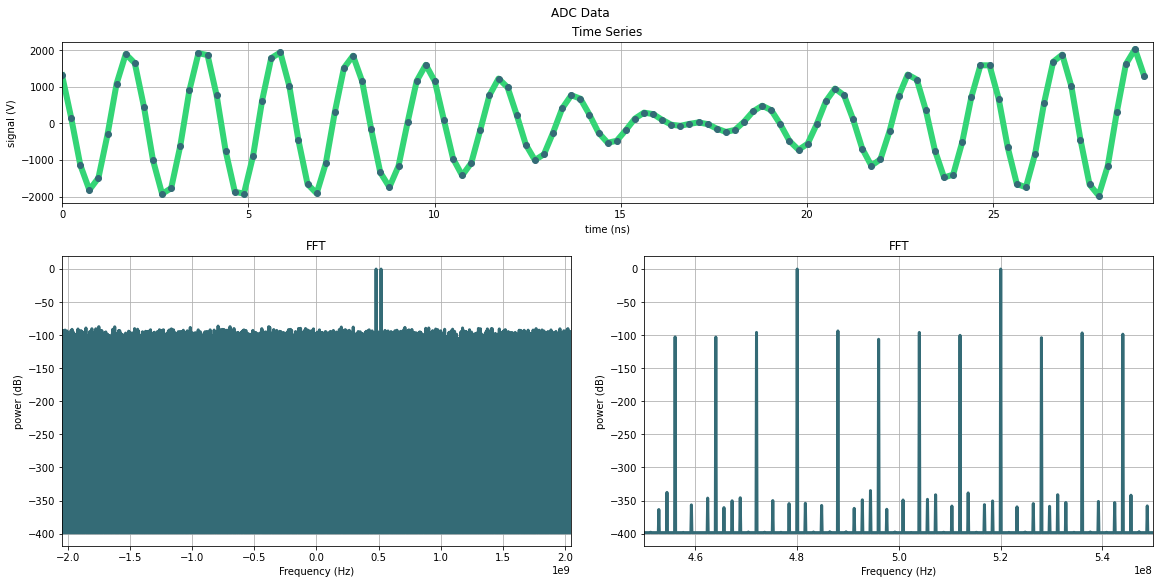

In [40]:
timerange = (0, 120)
fftrange = (16, 16 + 20*4096)
fftzoom = (4.5e8, 5.5e8)
adc_test_plot(xl, timerange, fftrange, fftzoom)

# 当直接用int读取dma数据，不使用右移4时，结果也正确

In [43]:
samples = 2**15
words_per_pkt = 2
dma = overlay.axi_dma_2
out_buffer = allocate(shape=(samples,32), dtype=np.int16, cacheable=1)
# out_buffer = allocate(shape=(samples*words_per_pkt,), dtype=int16, cacheable=1)

def dma_read():
    snapshot_ip.write(0x00,1)
    dma.recvchannel.transfer(out_buffer)
    dma.recvchannel.wait()
    snapshot_ip.write(0x00,0)

# configure snapshot block
# Note that the design will hang and become unresponsive if trying to
# start the snapshot block (writing to anything on this slave) prior to
# the RFDC running (in this case setting the clock starting digitizing)
snapshot_ip = overlay.snapshot_dac_testdata_0
snapshot_ip.write(0x10, samples)
# capture a snapshot and breakout IQ samples
dma_read()
print(out_buffer.shape)
print(out_buffer.max(),out_buffer.min())
print("original data\n")
for i in range(0,30):
    print(out_buffer[i])
x = out_buffer.reshape(-1,2)
print(x.shape)
print(x.max(),x.min())
print("reshape data\n")
for i in range(0,30):
    print(x[i])
# x=x>>4


print(x.shape)
print(x.max(),x.min())
print("un >>4 data\n")
for i in range(0,30):
    print(x[i])
np.savetxt("snapshot_data.txt",x)

# combine I and Q to form complex basebanded lowpass equivalent signal and compute spectrum
xl = x[:,0] + 1j*x[:,1]

del out_buffer

(32768, 32)
32672 -32704
original data

[ 21024  18304   2480  28288 -18144  22464 -29120   3648 -23840 -17840
  -4848 -29792  17408 -25120  30304  -6080  26304  16816   7328  30656
 -16128  27392 -30832   8592 -28336 -15312  -9824 -30848  14384 -29152
  30704 -11040]
[ 29840  13392  12208  30384 -12304  30368 -29920  13328 -30752 -11152
 -14368 -29296   9952 -30960  28544 -15312  31008   8736  16176  27632
  -7488  30896 -26608  16912 -30624  -6224 -17536 -25472   4992 -30176
  24240 -18032]
[ 29568   3776  18400  22896  -2608  28800 -21488  18608 -27872  -1488
 -18672 -20032    448 -26800  18512 -18576  25600   -512  18320  16960
   1376  24256 -15392  17904 -22800   2144 -17344 -13824  -2784 -21248
  12272 -16608]
[ 19584  -3312  15728  10752   3696  17856  -9280  14704 -16048   3952
 -13536  -7856  -4048 -14192   6512 -12240  12304  -4000  10800   5248
   3808  10400  -4080   9264  -8480   3472  -7616  -3024  -2976  -6576
   2080  -5872]
[ 4688 -2336  4048  1280  1552  2848  -592  

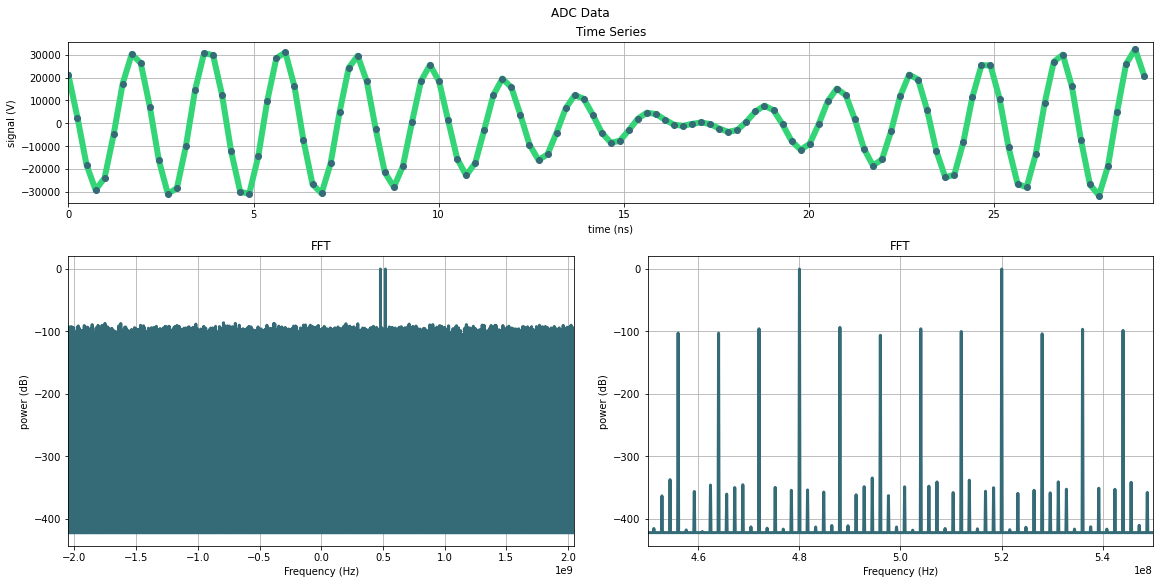

In [44]:
timerange = (0, 120)
fftrange = (16, 16 + 20*4096)
fftzoom = (4.5e8, 5.5e8)
adc_test_plot(xl, timerange, fftrange, fftzoom)

# 当直接用uint读取dma数据，直接转int,不使用右移4时，结果也正确

In [46]:
samples = 2**15
words_per_pkt = 2
dma = overlay.axi_dma_2
out_buffer = allocate(shape=(samples,32), dtype=np.int16, cacheable=1)
# out_buffer = allocate(shape=(samples*words_per_pkt,), dtype=int16, cacheable=1)

def dma_read():
    snapshot_ip.write(0x00,1)
    dma.recvchannel.transfer(out_buffer)
    dma.recvchannel.wait()
    snapshot_ip.write(0x00,0)

# configure snapshot block
# Note that the design will hang and become unresponsive if trying to
# start the snapshot block (writing to anything on this slave) prior to
# the RFDC running (in this case setting the clock starting digitizing)
snapshot_ip = overlay.snapshot_dac_testdata_0
snapshot_ip.write(0x10, samples)
# capture a snapshot and breakout IQ samples
dma_read()
print(out_buffer.shape)
print(out_buffer.max(),out_buffer.min())
print("original data\n")
for i in range(0,30):
    print(out_buffer[i])
x = out_buffer.reshape(-1,2)
print(x.shape)
print(x.max(),x.min())
print("reshape data\n")
for i in range(0,30):
    print(x[i])
# x=x>>4


print(x.shape)
print(x.max(),x.min())
print("un >>4 data\n")
for i in range(0,30):
    print(x[i])
np.savetxt("snapshot_data.txt",x)

# combine I and Q to form complex basebanded lowpass equivalent signal and compute spectrum
xl = x[:,0] + 1j*x[:,1]

del out_buffer

(32768, 32)
32672 -32704
original data

[ 21024  18304   2480  28288 -18144  22464 -29120   3648 -23840 -17840
  -4848 -29792  17408 -25120  30304  -6080  26304  16816   7328  30656
 -16128  27392 -30832   8592 -28336 -15312  -9824 -30848  14384 -29152
  30704 -11040]
[ 29840  13392  12208  30384 -12304  30368 -29920  13328 -30752 -11152
 -14368 -29296   9952 -30960  28544 -15312  31008   8736  16176  27632
  -7488  30896 -26608  16912 -30624  -6224 -17536 -25472   4992 -30176
  24240 -18032]
[ 29568   3776  18400  22896  -2608  28800 -21488  18608 -27872  -1488
 -18672 -20032    448 -26800  18512 -18576  25600   -512  18320  16960
   1376  24256 -15392  17904 -22800   2144 -17344 -13824  -2784 -21248
  12272 -16608]
[ 19584  -3312  15728  10752   3696  17856  -9280  14704 -16048   3952
 -13536  -7856  -4048 -14192   6512 -12240  12304  -4000  10800   5248
   3808  10400  -4080   9264  -8480   3472  -7616  -3024  -2976  -6576
   2080  -5872]
[ 4688 -2336  4048  1280  1552  2848  -592  

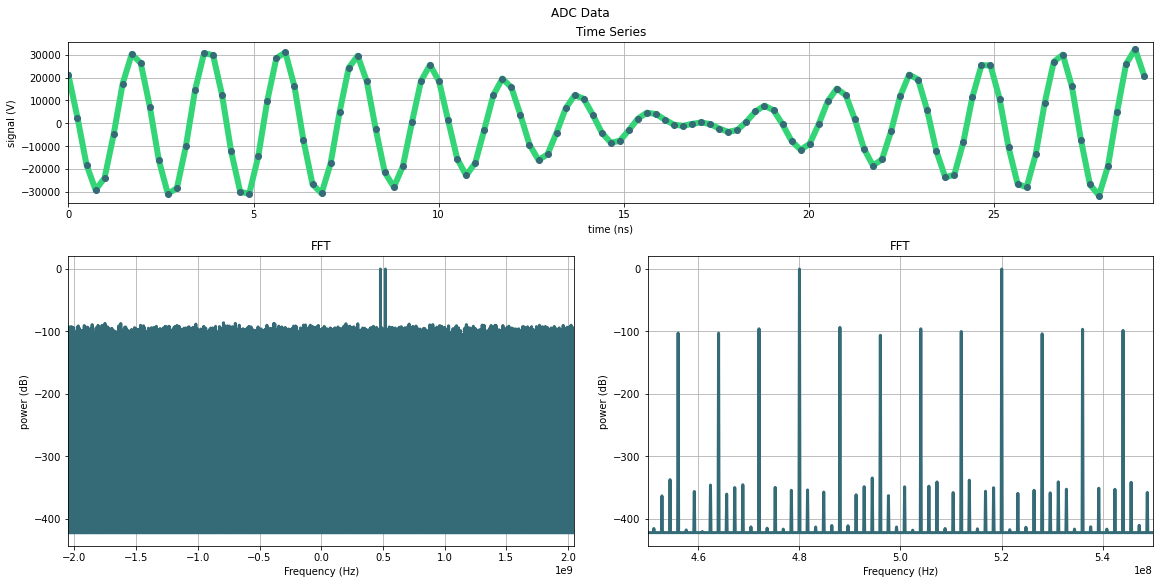

In [47]:
timerange = (0, 120)
fftrange = (16, 16 + 20*4096)
fftzoom = (4.5e8, 5.5e8)
adc_test_plot(xl, timerange, fftrange, fftzoom)